In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.base import clone

from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score, 
    roc_curve, 
    precision_recall_curve,
    confusion_matrix,
    auc)

from hyperopt import hp, fmin, tpe, Trials

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

Helper Functions

In [2]:
def show_stats(df):
    dtypes = df.dtypes
    nulls = df.isnull().sum()
    unique_count = df.apply(lambda x: x.nunique())
    columns = ['dtypes', 'null count', 'unique count']
    df_ = pd.concat([dtypes, nulls, unique_count], axis=1)
    df_.columns = columns
    return df_

In [3]:
def score_model(X_train, y_train, model, folds=3, scoring='roc_auc'):

    scores = cross_val_score(model, X_train, y_train, cv=folds, scoring=scoring, n_jobs=4, error_score='raise')
    return np.mean(scores), np.std(scores)

In [4]:
# returns a fitted estimator. for use with models with few parameters
def grid_search(X_train, y_train, model, param_grid, folds=10, scoring='roc_auc'):
    grid_mod = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=scoring, 
                            n_jobs=4, 
                            cv=folds,
                            verbose=1,
                            refit=False)
    
    grid_mod.fit(X_train, y_train)

    print(f'for {model.__class__.__name__}')
    print('Best Score: ', grid_mod.best_score_)
    print('Best Params: ', grid_mod.best_params_)
    return grid_mod.best_params_

Load The Data and prep

In [6]:
# load data
train_data_path = 'Twibot-20/data_creation/train_df_stage_1.json'
test_data_path = 'Twibot-20/data_creation/train_df_stage_1.json'
train_df = pd.read_json(train_data_path, index_col=[0])
test_df = pd.read_json(test_data_path, index_col=[0])

# train_df.set_index('ID', drop=True, inplace=True)
# test_df.set_index('ID', drop=True, inplace=True)

print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape)
print(train_df.columns)
train_df.sample(5)

Train shape:  (9395, 30)
Test shape:  (1176, 30)
Index(['profile', 'tweet', 'neighbor', 'domain', 'label', 'nn_signal',
       'lang_count', 'tweet_min_len', 'tweet_max_len', 'tweet_av_len',
       'tweet_len_std', 'user_name_len', 'screen_name_len', 'user_name_chars',
       'protected', 'verified', 'has_url', 'followers_count', 'friends_count',
       'favourites_count', 'days_old', 'listed_count', 'statuses_count',
       'description_len', 'sentiment', 'similarity', 'num_mentions',
       'num_links', 'retweet', 'num_tweets'],
      dtype='object')


,profile,tweet,neighbor,domain,label,nn_signal,lang_count,tweet_min_len,tweet_max_len,tweet_av_len,tweet_len_std,user_name_len,screen_name_len,user_name_chars,protected,verified,has_url,followers_count,friends_count,favourites_count,days_old,listed_count,statuses_count,description_len,sentiment,similarity,num_mentions,num_links,retweet,num_tweets
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48107626,"{'id': '48107626 ', 'id_str': '48107626 ', 'na...",['RT @WarTimeGirl: This is America. https://t...,"{'following': ['64486260', '4514671634', '1582...",['Politics'],0,0.334306,2,16,301,132.520000,87.225166,17,16,12,0,0,1,901,548,6069,4700,70,7639,154,Positive,0.639310,170.0,1.0,0.0,1
580829979,"{'id': '580829979 ', 'id_str': '580829979 ', '...",['RT @honigstein: Devastating impact by Alexis...,"{'following': ['914546558', '18481050', '21595...",['Sports'],1,0.811788,1,27,141,120.560000,28.209155,18,13,13,0,0,0,303,147,0,3637,12,770,159,Positive,0.772988,32.0,1.0,0.0,1
172466166,"{'id': '172466166 ', 'id_str': '172466166 ', '...",['RT @jemelehill: The NBA season is going to b...,"{'following': ['23483324', '164354823', '87044...",['Politics'],1,0.488446,1,9,302,121.436548,67.139617,5,13,5,0,0,0,437,2358,52395,4293,6,12940,91,Positive,0.728017,159.0,1.0,0.0,1
2560180003,"{'id': '2560180003 ', 'id_str': '2560180003 ',...","[""@SenBobCorker You've got jack shit corrupt R...","{'following': ['114557610', '2771678740', '271...",['Sports'],1,0.953401,1,24,309,127.940789,54.222281,9,14,7,0,0,0,2021,4057,865,2880,1,3060,32,Negative,0.761517,202.0,1.0,0.0,1
37945489,"{'id': '37945489 ', 'id_str': '37945489 ', 'na...",['@EmilieRadioFr @marieclaire_fr @SophieFontan...,"{'following': ['2706459692', '17207345', '6903...",['Politics'],0,0.222965,3,16,291,118.335000,50.166052,20,14,13,0,1,1,104446,1188,9606,4743,228,9602,143,Positive,0.473816,248.0,1.0,0.0,1


In [6]:
train_df.drop(['profile', 'tweet', 'neighbor', 'domain'], axis=1, inplace=True)
test_df.drop(['profile', 'tweet', 'neighbor', 'domain'], axis=1, inplace=True)
train_df.shape

(9395, 22)

In [7]:
print('train_df')
display(show_stats(train_df))
print('test_df')
show_stats(test_df)

train_df


,dtypes,null count,unique count
label,int64,0,2
nn_signal,float64,0,9331
lang_count,int64,0,17
tweet_min_len,int64,0,151
tweet_max_len,int64,0,548
tweet_av_len,float64,0,8659
tweet_len_std,float64,0,9250
user_name_len,int64,0,50
screen_name_len,int64,0,14
user_name_chars,int64,0,31


test_df


,dtypes,null count,unique count
label,int64,0,2
nn_signal,float64,0,1172
lang_count,int64,0,17
tweet_min_len,int64,0,95
tweet_max_len,int64,0,274
tweet_av_len,float64,0,1159
tweet_len_std,float64,0,1161
user_name_len,int64,0,46
screen_name_len,int64,0,13
user_name_chars,int64,0,25


In [8]:
sentement_dict = {
    'Positive': 1,
    'Negative': 0
}

train_df['sentiment'] = train_df['sentiment'].apply(lambda x: sentement_dict[x])
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: sentement_dict[x])

In [9]:
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']

X_test = test_df.drop(['label'], axis=1)
y_test = test_df['label']

Scale Data

In [10]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Initial Baseline Model

In [11]:
baseline_model = LogisticRegression()
score_model(X_train, y_train, baseline_model, folds=10)

(0.9404497704373718, 0.009079271510555782)

Linear Models

Logistic Regression

In [12]:
# train / gridsearch Logistic Regression
lr_model = LogisticRegression()

lr_param_grid = {'C': [.001, .01, .1, 1, 10]}
best_lr_params = grid_search(X_train, y_train, lr_model, lr_param_grid)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
for LogisticRegression
Best Score:  0.9406986812285207
Best Params:  {'C': 0.1}


In [13]:
best_lr_model = LogisticRegression(**best_lr_params)

SGDClassifier

In [14]:


sgd_param_grid = {'l1_ratio': hp.uniform('l1_ratio', 0, 1),
                  'learning_rate': hp.choice(
                      'learning_rate', [{
                          'type': 'optimal',
                          'alpha': hp.lognormal('alpha', 0, .5)
                      },
                      {
                          'type': 'invscaling',
                          'power_t': hp.normal('power_t', 0, 1)
                      }]
                  ),
                  'eta0': hp.lognormal('eta0', 0, 1)}

def sgd_objective(search_space):
    # im setting the loss function to 'modified_huber' loss as other losses create a 
    # logistic regression and linear svm model while others are for regression. 
    # modified_huber is also robust to outliers
    l1_ratio = search_space['l1_ratio']
    learning_rate = search_space['learning_rate']['type']
    eta0 = search_space['eta0']
    if 'alpha' in search_space['learning_rate']:
        learning_param = search_space['learning_rate']['alpha']
        sgd_model = SGDClassifier(loss='modified_huber', 
                                  penalty='elasticnet', 
                                  l1_ratio=l1_ratio,
                                  learning_rate=learning_rate,
                                  alpha=learning_param,
                                  eta0=eta0)
    else:
        learning_param = search_space['learning_rate']['power_t']
        sgd_model = SGDClassifier(loss='modified_huber', 
                                  penalty='elasticnet', 
                                  l1_ratio=l1_ratio,
                                  learning_rate=learning_rate,
                                  power_t=learning_param,
                                  eta0=eta0)


    score, _ = score_model(X_train, y_train, sgd_model)
    return -1 * np.mean(score)

In [15]:
trials = Trials()
max_evals = 500
sgd_best_params = fmin(fn=sgd_objective, space=sgd_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
sgd_best_params

100%|██████████| 1000/1000 [07:28<00:00,  2.23trial/s, best loss: -0.9407146617536731]


{'eta0': 0.28808306853240345,
 'l1_ratio': 0.6688109260767467,
 'learning_rate': 1,
 'power_t': 0.7736480913102951}

In [16]:
l1_ratio = sgd_best_params['l1_ratio']
learning_rate = 'optimal' if sgd_best_params['learning_rate'] == 0 else 'invscaling'
eta0 = sgd_best_params['eta0']

if learning_rate == 'optimal':
    alpha = sgd_best_params['alpha']
    best_sgd_model = SGDClassifier(loss='modified_huber', 
                                penalty='elasticnet', 
                                learning_rate=learning_rate, 
                                l1_ratio=l1_ratio, 
                                eta0=eta0,
                                alpha=alpha)
else:
    power_t = sgd_best_params['power_t']
    best_sgd_model = SGDClassifier(loss='modified_huber', 
                                penalty='elasticnet', 
                                learning_rate=learning_rate, 
                                l1_ratio=l1_ratio, 
                                eta0=eta0,
                                power_t=power_t)

Tree Based Models

LightGBM

In [17]:


lgbm_param_grid = {'reg_alpha': hp.lognormal('reg_alpha', 0, .5),
                   'reg_lambda': hp.lognormal('reg_lambda', 0, .5),
                   'subsample': hp.uniform('subsample', 0, 1),
                   'num_leaves': hp.quniform('num_leaves', 10, 100, 1),
                   'max_depth': hp.quniform('max_depth', 1, 10, 1),
                   'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
                   'learning_rate': hp.loguniform('learning_rate', -3, 0)}

def lgbm_objective(search_space):
    reg_alpha = search_space['reg_alpha']
    reg_lambda = search_space['reg_lambda']
    subsample = search_space['subsample']
    num_leaves = search_space['num_leaves']
    max_depth = search_space['max_depth']
    n_estimators = search_space['n_estimators']
    learning_rate = search_space['learning_rate']
    
    lgbm_model = LGBMClassifier(reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                subsample=subsample,
                                num_leaves=int(num_leaves),
                                max_depth=int(max_depth),
                                n_estimators=int(n_estimators),
                                learning_rate=learning_rate)

    score, _ = score_model(X_train, y_train, lgbm_model)
    return -1 * np.mean(score)

In [18]:
trials = Trials()
max_evals = 500
lgbm_best_params = fmin(fn=lgbm_objective, space=lgbm_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
lgbm_best_params

100%|██████████| 500/500 [09:23<00:00,  1.13s/trial, best loss: -0.9420043032375826]


{'learning_rate': 0.12330475868991779,
 'max_depth': 3.0,
 'n_estimators': 92.0,
 'num_leaves': 82.0,
 'reg_alpha': 1.2700423785403265,
 'reg_lambda': 0.704877931498582,
 'subsample': 0.22709731125588928}

In [19]:

reg_alpha = lgbm_best_params['reg_alpha']
reg_lambda = lgbm_best_params['reg_lambda']
subsample = lgbm_best_params['subsample']
num_leaves = lgbm_best_params['num_leaves']
max_depth = lgbm_best_params['max_depth']
n_estimators = lgbm_best_params['n_estimators']
learning_rate = lgbm_best_params['learning_rate']

best_lgbm_model = LGBMClassifier(reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                subsample=subsample,
                                num_leaves=int(num_leaves),
                                max_depth=int(max_depth),
                                n_estimators=int(n_estimators),
                                learning_rate=learning_rate)

Random Forest

In [20]:

rf_param_grid = {'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
                 'max_depth': hp.quniform('max_depth', 2, 20, 1),
                 'max_features': hp.choice('max_features', ['auto', 'sqrt']),
                 'min_samples_split': hp.quniform('min_samples_split', 2, 5, 1),
                 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)}

def rf_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    max_features = search_space['max_features']
    min_samples_split = search_space['min_samples_split']
    min_samples_leaf = search_space['min_samples_leaf']

    rf_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                      max_depth=int(max_depth),
                                      max_features=max_features,
                                      min_samples_split=int(min_samples_split),
                                      min_samples_leaf=int(min_samples_leaf))

    score, _ = score_model(X_train, y_train, rf_model)
    return -1 * np.mean(score)

In [21]:
trials = Trials()
max_evals = 200
rf_best_params = fmin(fn=rf_objective, space=rf_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
rf_best_params

100%|██████████| 300/300 [58:33<00:00, 11.71s/trial, best loss: -0.9402555953322783] 


{'max_depth': 10.0,
 'max_features': 1,
 'min_samples_leaf': 5.0,
 'min_samples_split': 5.0,
 'n_estimators': 254.0}

In [22]:
n_estimators = rf_best_params['n_estimators']
max_depth = rf_best_params['max_depth']
max_features = rf_best_params['max_features']
min_samples_split = rf_best_params['min_samples_split']
min_samples_leaf = rf_best_params['min_samples_leaf']

best_rf_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_depth=int(max_depth),
                                       max_features= 'auto' if max_features == 0 else 'sqrt',
                                       min_samples_split=int(min_samples_split),
                                       min_samples_leaf=int(min_samples_leaf))

Adaboost

In [23]:

ada_param_grid = {'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
                  'max_depth': hp.quniform('max_depth', 1, 3, 1),
                  'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                  'learning_rate': hp.loguniform('learning_rate', -3, 8)}

def ada_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    min_samples_split = search_space['min_samples_split']
    learning_rate = search_space['learning_rate']

    ada_model = AdaBoostClassifier(n_estimators=int(n_estimators),
                                   learning_rate=learning_rate,
                                   base_estimator=DecisionTreeClassifier(max_depth=int(max_depth),
                                                                         min_samples_split=int(min_samples_split)))

    score, _ = score_model(X_train, y_train, ada_model)
    return -1 * np.mean(score)

In [24]:
trials = Trials()
max_evals = 200
ada_best_params = fmin(fn=ada_objective, space=ada_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
ada_best_params

100%|██████████| 200/200 [26:31<00:00,  7.96s/trial, best loss: -0.9421041044005812]


{'learning_rate': 0.05418682720067697,
 'max_depth': 2.0,
 'min_samples_split': 6.0,
 'n_estimators': 97.0}

In [25]:
n_estimators = ada_best_params['n_estimators']
max_depth = ada_best_params['max_depth']
min_samples_split = ada_best_params['min_samples_split']
learning_rate = ada_best_params['learning_rate']

best_ada_model = AdaBoostClassifier(n_estimators=int(n_estimators),
                                    learning_rate=learning_rate,
                                    base_estimator=DecisionTreeClassifier(max_depth=int(max_depth),
                                                                          min_samples_split=int(min_samples_split)))

Support Vector Machine

SVC

In [30]:


svc_param_grid = {'C': hp.loguniform('C', -5, 4),
                  'kernal': hp.choice('kernal', [{
                      'type': 'linear'
                  },
                  {
                      'type': 'rbf',
                      'gamma': hp.loguniform('gamma', -9, 3)
                  }])}

def svc_objective(search_space):
    C = search_space['C']
    kernal = search_space['kernal']['type']
    if kernal == 'rbf':
        gamma = search_space['kernal']['gamma']
        svc_model = SVC(C=C,
                        kernel=kernal,
                        gamma=gamma,
                        probability=True)
    else:
        svc_model = SVC(C=C,
                        kernel=kernal,
                        probability=True)

    score, _ = score_model(X_train, y_train, svc_model)
    return -1 * np.mean(score)

In [31]:
trials = Trials()
max_evals = 100
svc_best_params = fmin(fn=svc_objective, space=svc_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
svc_best_params

100%|██████████| 100/100 [29:50<00:00, 17.90s/trial, best loss: -0.9402777926590895]


{'C': 40.22734081742408, 'gamma': 0.0007263914100970921, 'kernal': 1}

In [42]:
C = svc_best_params['C']
kernel = 'linear' if svc_best_params['kernal'] == 0 else 'rbf'
if kernel == 'rbf':
    gamma = svc_best_params['gamma']
    best_svc_model = SVC(C=C,
                         kernel=kernel,
                         gamma=gamma,
                         probability=True)
else:
    best_svc_model = SVC(C=C,
                         kernal=kernel,
                         probability=True)

Voting Classifier

In [43]:
vote_classifier = VotingClassifier(estimators=[('LogisticRegression', best_lr_model), 
                                               ('SGDClassifier', best_sgd_model), 
                                               ('LGBMClassifier', best_lgbm_model), 
                                               ('RandomForestClassifier', best_rf_model), 
                                               ('AdaBoostClassifier', best_ada_model), 
                                               ('SVC', best_svc_model)],
                                   voting='soft')

In [44]:
mean, std = score_model(X_train, y_train, vote_classifier, folds=5)
print('mean roc_auc score: ', mean, ' std: ', std)

mean roc_auc score:  0.9426120510946557  std:  0.0042691210170679285


Stacking Classifier

In [47]:
stack_classifier = StackingClassifier(estimators=[('LogisticRegression', best_lr_model), 
                                                  ('SGDClassifier', best_sgd_model), 
                                                  ('LGBMClassifier', best_lgbm_model), 
                                                  ('RandomForestClassifier', best_rf_model), 
                                                  ('AdaBoostClassifier', best_ada_model), 
                                                  ('SVC', best_svc_model)],
                                      final_estimator=LogisticRegression())

In [48]:
mean, std = score_model(X_train, y_train, stack_classifier, folds=5)
print('mean roc_auc score: ', mean, ' std: ', std)

mean roc_auc score:  0.9428280864325211  std:  0.004612934829367237


Results and Analysis

In [68]:
def test_model(X_train, y_train, X_test, y_test, model):
    mod = clone(model)
    mod.fit(X_train, y_train)
    y_probs = mod.predict_proba(X_test)
    y_preds = mod.predict(X_test)
    results = pd.Series(index=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'], dtype='float64')
    results.loc['roc_auc'] = roc_auc_score(y_test, y_probs[:, 1])
    results.loc['accuracy'] = accuracy_score(y_test, y_preds)
    results.loc['precision'] = precision_score(y_test, y_preds)
    results.loc['recall'] = recall_score(y_test, y_preds)
    results.loc['f1'] = f1_score(y_test, y_preds, average='macro')

    conf_matrix = confusion_matrix(y_test, y_preds)

    print('Metrics:')
    display(results)

    print('\nConfusion Matrix:\n')
    print('                  Predicted Positive   Predicted Negative')
    print('Actual Positive |        {tp:>3}        |        {fn:>3}        |'.format(tp=conf_matrix[0, 0], fn=conf_matrix[0, 1]))
    print('Actual Negative |        {fp:>3}        |        {tn:>3}        |'.format(fp=conf_matrix[1, 0], tn=conf_matrix[1, 1]))
    print()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    print('\nRoc Auc curve:')
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    sns.lineplot(x=fpr, y=tpr, ax=ax[0], label=f'Roc Auc score={auc(fpr, tpr)}')
    ax[0].plot([0, 1],[0, 1], linestyle='--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic')

    pre, rec, _ = precision_recall_curve(y_test, y_probs[:, 1])
    sns.lineplot(x=rec, y=pre, ax=ax[1])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision Recall Curve')

    plt.tight_layout()
    plt.show()

Metrics:


roc_auc      0.914124
accuracy     0.843537
precision    0.833572
recall       0.895223
f1           0.840198
dtype: float64


Confusion Matrix:

                  Predicted Positive   Predicted Negative
Actual Positive |        411        |        116        |
Actual Negative |         68        |        581        |


Roc Auc curve:


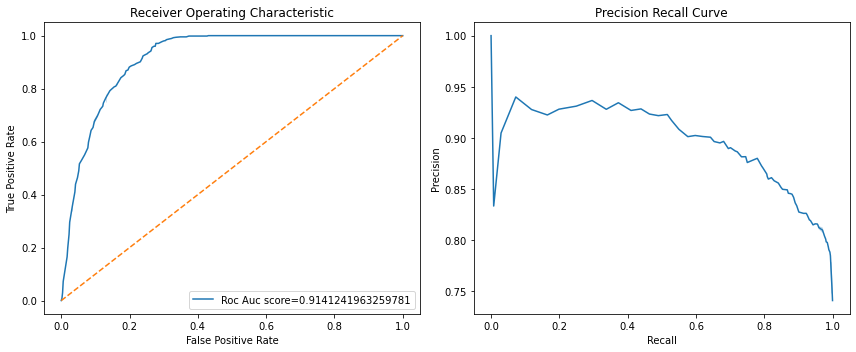

In [72]:
test_model(X_train, y_train, X_test, y_test, LogisticRegression())

Metrics:


roc_auc      0.915789
accuracy     0.846088
precision    0.839130
recall       0.892142
f1           0.843074
dtype: float64


Confusion Matrix:

                  Predicted Positive   Predicted Negative
Actual Positive |        416        |        111        |
Actual Negative |         70        |        579        |


Roc Auc curve:


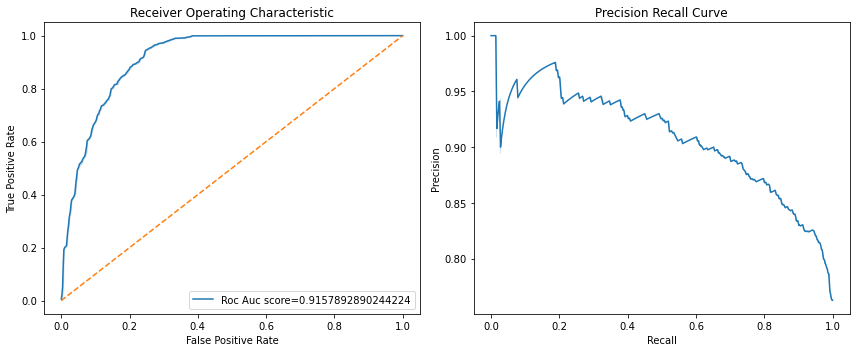

In [70]:
test_model(X_train, y_train, X_test, y_test, vote_classifier)

Metrics:


roc_auc      0.914705
accuracy     0.846939
precision    0.841339
recall       0.890601
f1           0.844052
dtype: float64


Confusion Matrix:

                  Predicted Positive   Predicted Negative
Actual Positive |        418        |        109        |
Actual Negative |         71        |        578        |


Roc Auc curve:


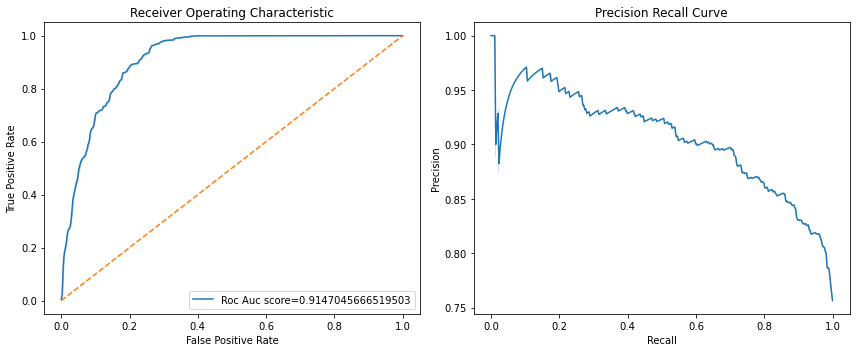

In [71]:
test_model(X_train, y_train, X_test, y_test, stack_classifier)